# Rockland: Neuroticism and Adult Self Report
*based on code by Rob Chavez - May 2nd, 2019*

<img src="http://compsan.org/images/CSAN_Logo.svg" alt="drawing" width="100"/> 

In [166]:
%matplotlib inline
from nltools.data import Brain_Data
from nilearn import plotting, image, input_data, datasets
import numpy as np
import pandas as pd
import os
import nltools as nlt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from nltools.plotting import plot_brain


# Load data

Here we load the group 4D file which contains each subject's fractional anisotropy file registered to standard space. This space is then masked by areas which showed high SNR across subjects. Included in the behavioral data is a randomly generated training/testing label for splitting the data.

In [2]:
os.chdir("/Users/moriahstendel/Downloads/")
behav = pd.read_csv('rockland_519_with_big_five.csv')
behav = behav.fillna(0)
behav['ID'] = np.arange(1,520)

In [3]:
# Load FA data
fa_data = Brain_Data('mo.merge.nii.gz', mask = 'mo_mask_thresholded.nii.gz', X = behav)

# plot masked mean FA
#fa_data.mean().plot()

In [4]:
behav.head(5)

,Unnamed: 0,V1,ID,VISIT,SUB_STUDY.x,DEM_001,DEM_002,DEM_003,DEM_004,DEM_006,...,NEOFFI_63,NEOFFI_64,NEOFFI_65,NEOFFI_66,NEOFFI_67,NEOFFI_68,NEOFFI_69,NEOFFI_70,NEOFFI_72,NEOFFI_73
0,1,1,1,VA-REP,Neurofeedbac,30.0,1,0,5,1.0,...,34.0,26.0,19.0,1,30,70,55,61,43,28
1,2,2,2,VA,Discoverysci,56.0,2,0,5,1.0,...,0.0,0.0,0.0,2,56,25,25,25,25,25
2,3,3,3,VA,Discoverysci,55.0,1,0,5,1.0,...,31.0,30.0,39.0,1,55,40,60,56,50,61
3,4,4,4,VA,Discoverysci,53.0,2,0,5,1.0,...,36.0,39.0,40.0,2,53,51,65,61,59,61
4,5,5,5,VA,Discoverysci,57.0,1,0,5,1.0,...,40.0,24.0,42.0,1,57,39,32,70,39,66


# Fit neuroticism model
Here we will fit the ridge regression model on the training data using a leave-one-out cross-validation and a alpha =.1. 

In [167]:
# split data one train/test
train = fa_data[fa_data.X['category']=='train']
subject_id = train.X['ID']
train.Y = train.X['NEOFFI_68']

test = fa_data[fa_data.X['category']=='test']
test.Y = test.X['NEOFFI_68']

# fit model
stats_neuroticism= train.predict(algorithm='ridge',plot=False, 
                         cv_dict={'type': 'loso','subject_id':subject_id},
                         **{'alpha':.1})

# save weight map for use later
neuroticism_weightmap = stats_neuroticism['weight_map'].data



overall Root Mean Squared Error: 0.00
overall Correlation: 1.00
overall CV Root Mean Squared Error: 11.03
overall CV Correlation: 0.31


# Apply model to test sample
Here we will apply the model to the out-of-sample data, print a scatter plot and summary stats.

Holdout: R = 0.26347481818278395, p = 0.0006526141180018411, R2 = 0.06941897981645107, RMSE =  10.85653519772591
Plotting unthresholded image


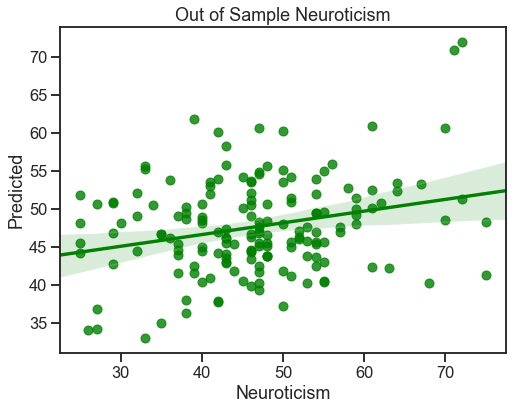

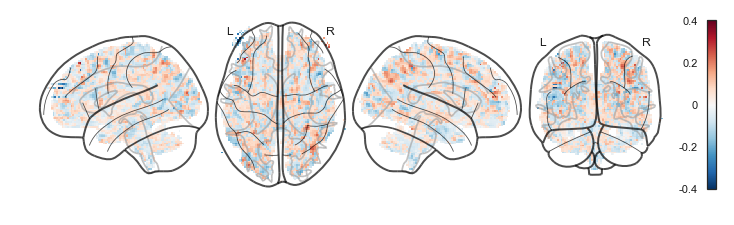

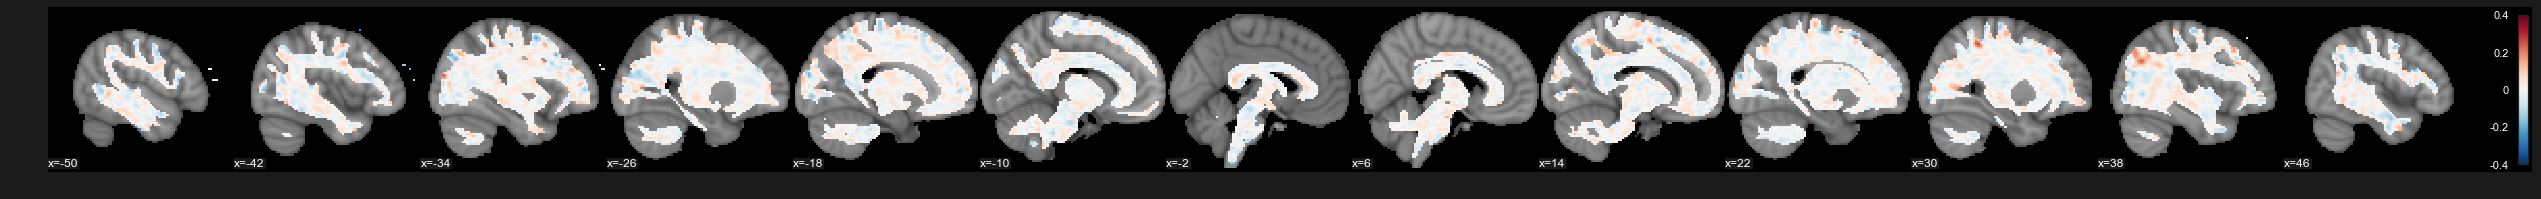

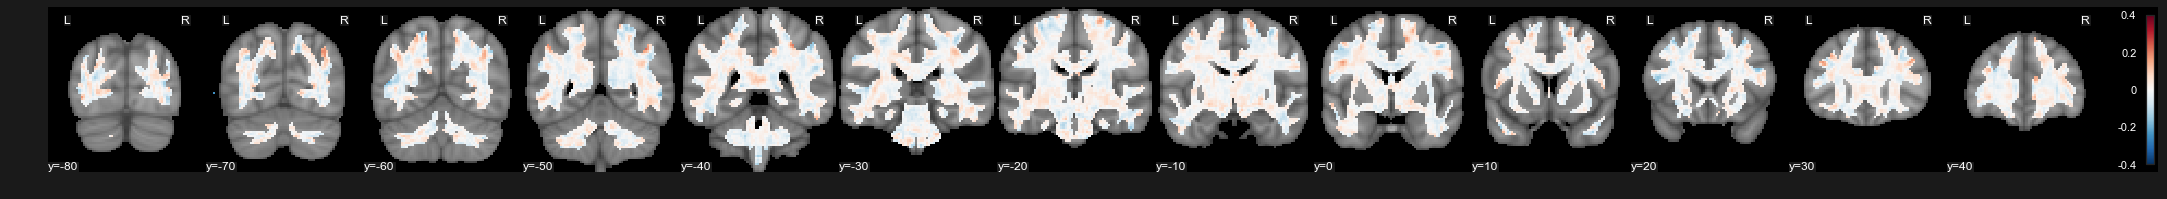

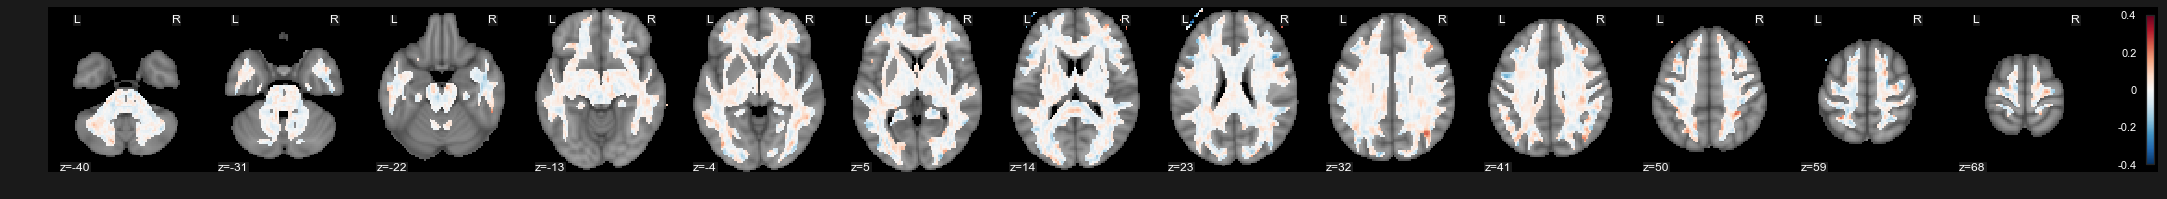

In [170]:
# apply predictions to holdout data
predicted_neuroticism = test.similarity(stats_neuroticism['weight_map'],'dot_product') + stats_neuroticism['intercept']

data_neurotic = pd.DataFrame(data={'ID':test.X['ID'],'Predicted':predicted_neuroticism,'neuroticism':test.X['NEOFFI_68']})

# scatter plot of predicted values
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("ticks")
with sns.plotting_context(context='talk',font_scale=1):
    sns.regplot(data=data_neurotic,x='neuroticism',y='Predicted', color='green').set_title("Out of Sample Neuroticism")
    plt.xlabel('Neuroticism')

# calculate fit metrics    
fit = pearsonr(data_neurotic.neuroticism, data_neurotic.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_neurotic.neuroticism, data_neurotic.Predicted))


print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse))

# plot brain
plot_brain(stats_neuroticism['weight_map'])

## Apply neuroticism model to psychopathology variables
Here we will use the weight map from the neuroticism analysis to test its predictive utility on adult-self report T-score data.

### Internalizing:

Holdout: R = -0.21354902473814144, p = 0.006040234859890268, R2 = 0.045603185966611344, RMSE =  19.407807785967556


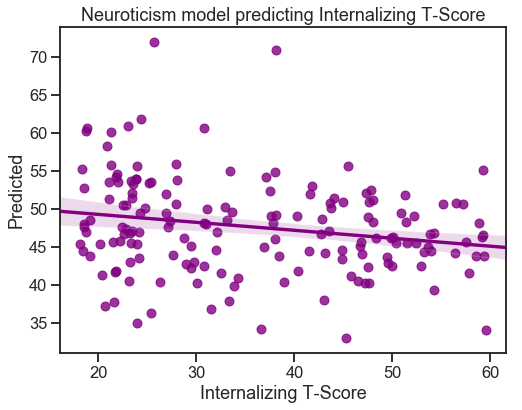

In [175]:
# apply predictions to holdout data
predicted_neuroticism = test.similarity(stats_neuroticism['weight_map'],'dot_product') + stats_neuroticism['intercept']

data_neurotic = pd.DataFrame(data={'SubjectID':test.X['ID'],'Predicted':predicted_neuroticism,'internalizing_tscore':test.X['ASRM_147']})

# scatter plot of predicted values
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("ticks")
with sns.plotting_context(context='talk',font_scale=1):
    sns.regplot(data=data_neurotic,x='internalizing_tscore',y='Predicted', color='purple').set_title("Neuroticism model predicting Internalizing T-Score")
    plt.xlabel('Internalizing T-Score')
        
# calculate fit metrics    
fit = pearsonr(data_neurotic.internalizing_tscore, data_neurotic.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_neurotic.internalizing_tscore, data_neurotic.Predicted))

print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse))


### Externalizing 

Holdout: R = 0.02201908754675666, p = 0.7795856726825573, R2 = 0.00048484021639173423, RMSE =  28.74744787344848


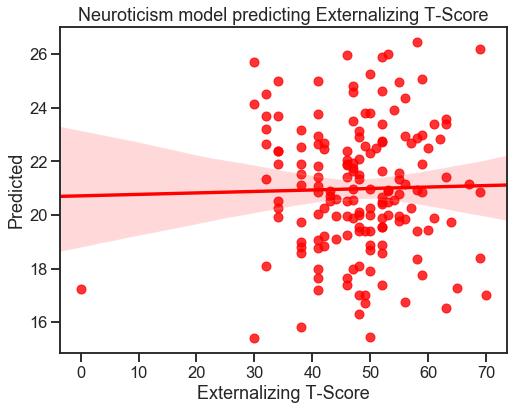

In [120]:
# apply predictions to holdout data
predicted_neuroticism = test.similarity(stats_neuroticism['weight_map'],'dot_product') + stats_neuroticism['intercept']

data_neurotic = pd.DataFrame(data={'SubjectID':test.X['ID'],'Predicted':predicted_neuroticism,'externalizing_tscore':test.X['ASRM_158']})

# scatter plot of predicted values
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("ticks")
with sns.plotting_context(context='talk',font_scale=1):
    sns.regplot(data=data_neurotic,x='externalizing_tscore',y='Predicted', color='red').set_title("Neuroticism model predicting Externalizing T-Score")
    plt.xlabel('Externalizing T-Score')

# calculate fit metrics    
fit = pearsonr(data_neurotic.externalizing_tscore, data_neurotic.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_neurotic.externalizing_tscore, data_neurotic.Predicted))

print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse))


### Anxious/Depressed:

Holdout: R = 0.06310350675718139, p = 0.42212590148412743, R2 = 0.003982052565053637, RMSE =  33.1393071972287


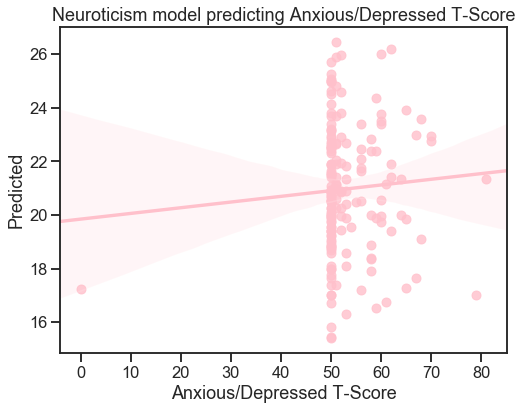

In [121]:
# apply predictions to holdout data
predicted_neuroticism = test.similarity(stats_neuroticism['weight_map'],'dot_product') + stats_neuroticism['intercept']

data_neurotic = pd.DataFrame(data={'SubjectID':test.X['ID'],'Predicted':predicted_neuroticism,'anxious_depressed_tscore':test.X['ASRM_148']})

# scatter plot of predicted values
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("ticks")
with sns.plotting_context(context='talk',font_scale=1):
    sns.regplot(data=data_neurotic,x='anxious_depressed_tscore',y='Predicted', color='pink').set_title("Neuroticism model predicting Anxious/Depressed T-Score")
    plt.xlabel('Anxious/Depressed T-Score')

# calculate fit metrics    
fit = pearsonr(data_neurotic.anxious_depressed_tscore, data_neurotic.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_neurotic.anxious_depressed_tscore, data_neurotic.Predicted))

print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse))

### Withdrawn:

Holdout: R = 0.05418640742190626, p = 0.4907456050071648, R2 = 0.0029361667492928175, RMSE =  33.88577079399808


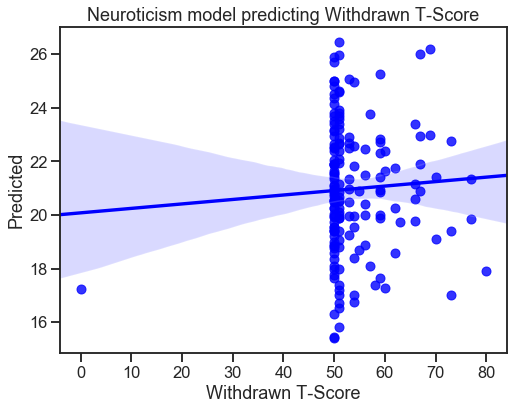

In [122]:
# apply predictions to holdout data
predicted_neuroticism = test.similarity(stats_neuroticism['weight_map'],'dot_product') + stats_neuroticism['intercept']

data_neurotic = pd.DataFrame(data={'SubjectID':test.X['ID'],'Predicted':predicted_neuroticism,'withdrawn_tscore':test.X['ASRM_149']})

# scatter plot of predicted values
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("ticks")
with sns.plotting_context(context='talk',font_scale=1):
    sns.regplot(data=data_neurotic,x='withdrawn_tscore',y='Predicted', color='blue').set_title("Neuroticism model predicting Withdrawn T-Score")
    plt.xlabel('Withdrawn T-Score')

# calculate fit metrics    
fit = pearsonr(data_neurotic.withdrawn_tscore, data_neurotic.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_neurotic.withdrawn_tscore, data_neurotic.Predicted))

print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse))

### Somatic:

Holdout: R = 0.1423312193662073, p = 0.06905579001355744, R2 = 0.020258176006271424, RMSE =  33.29201272178301


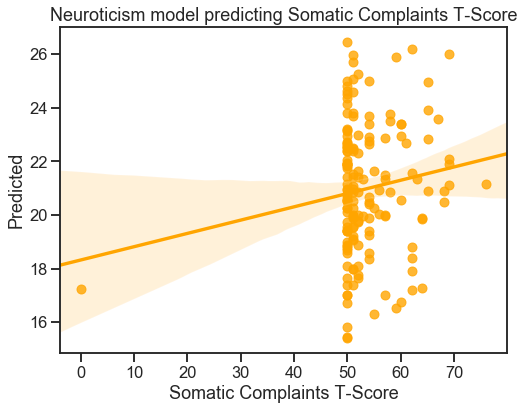

In [123]:
# apply predictions to holdout data
predicted_neuroticism = test.similarity(stats_neuroticism['weight_map'],'dot_product') + stats_neuroticism['intercept']

data_neurotic = pd.DataFrame(data={'SubjectID':test.X['ID'],'Predicted':predicted_neuroticism,'somatic_tscore':test.X['ASRM_150']})

# scatter plot of predicted values
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("ticks")
with sns.plotting_context(context='talk',font_scale=1):
    sns.regplot(data=data_neurotic,x='somatic_tscore',y='Predicted', color='orange').set_title("Neuroticism model predicting Somatic Complaints T-Score")
    plt.xlabel('Somatic Complaints T-Score')

# calculate fit metrics    
fit = pearsonr(data_neurotic.somatic_tscore, data_neurotic.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_neurotic.somatic_tscore, data_neurotic.Predicted))

print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse))

### Thought Problems:

Holdout: R = 0.10031589482116028, p = 0.20122454125442113, R2 = 0.010063278753770092, RMSE =  31.61970243655695


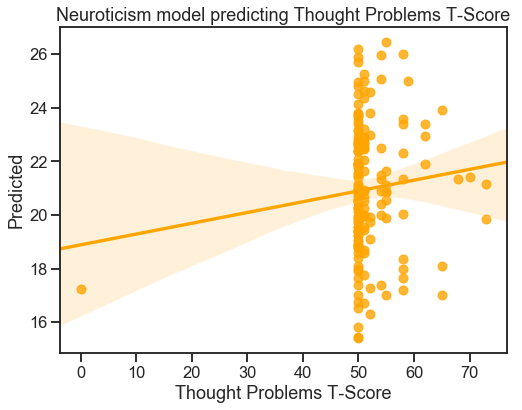

In [124]:
# apply predictions to holdout data
predicted_neuroticism = test.similarity(stats_neuroticism['weight_map'],'dot_product') + stats_neuroticism['intercept']

data_neurotic = pd.DataFrame(data={'SubjectID':test.X['ID'],'Predicted':predicted_neuroticism,'thought_tscore':test.X['ASRM_151']})

# scatter plot of predicted values
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("ticks")
with sns.plotting_context(context='talk',font_scale=1):
    sns.regplot(data=data_neurotic,x='thought_tscore',y='Predicted', color='orange').set_title("Neuroticism model predicting Thought Problems T-Score")
    plt.xlabel('Thought Problems T-Score')

# calculate fit metrics    
fit = pearsonr(data_neurotic.thought_tscore, data_neurotic.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_neurotic.thought_tscore, data_neurotic.Predicted))

print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse))

### Attention Problems:

Holdout: R = 0.05827138729356463, p = 0.45859636106460666, R2 = 0.0033955545771166057, RMSE =  34.29409473864555


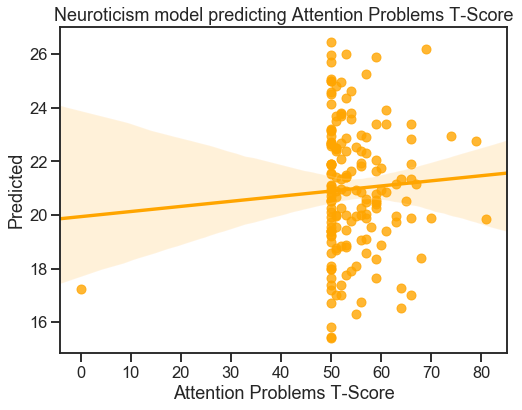

In [125]:
# apply predictions to holdout data
predicted_neuroticism = test.similarity(stats_neuroticism['weight_map'],'dot_product') + stats_neuroticism['intercept']

data_neurotic = pd.DataFrame(data={'SubjectID':test.X['ID'],'Predicted':predicted_neuroticism,'attn_tscore':test.X['ASRM_152']})

# scatter plot of predicted values
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("ticks")
with sns.plotting_context(context='talk',font_scale=1):
    sns.regplot(data=data_neurotic,x='attn_tscore',y='Predicted', color='orange').set_title("Neuroticism model predicting Attention Problems T-Score")
    plt.xlabel('Attention Problems T-Score')

# calculate fit metrics    
fit = pearsonr(data_neurotic.attn_tscore, data_neurotic.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_neurotic.attn_tscore, data_neurotic.Predicted))

print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse)) 

### Aggressive Behaviour:

Holdout: R = 0.09390573487164923, p = 0.23168612816065953, R2 = 0.008818287041784478, RMSE =  32.14788725489956


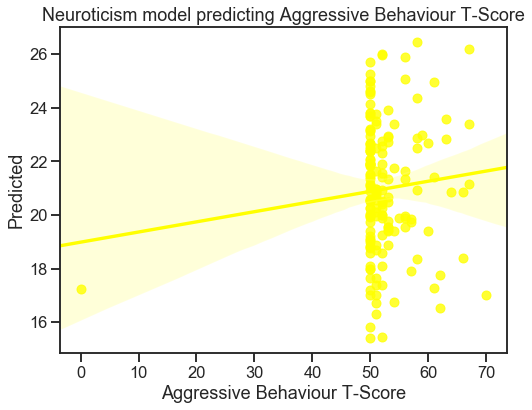

In [126]:
# apply predictions to holdout data
predicted_neuroticism = test.similarity(stats_neuroticism['weight_map'],'dot_product') + stats_neuroticism['intercept']

data_neurotic = pd.DataFrame(data={'SubjectID':test.X['ID'],'Predicted':predicted_neuroticism,'agg_tscore':test.X['ASRM_153']})

# scatter plot of predicted values
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("ticks")
with sns.plotting_context(context='talk',font_scale=1):
    sns.regplot(data=data_neurotic,x='agg_tscore',y='Predicted', color='yellow').set_title("Neuroticism model predicting Aggressive Behaviour T-Score")
    plt.xlabel('Aggressive Behaviour T-Score')

# calculate fit metrics    
fit = pearsonr(data_neurotic.agg_tscore, data_neurotic.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_neurotic.agg_tscore, data_neurotic.Predicted))

print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse)) 

### Rule Breaking:

Holdout: R = 0.08807316986915896, p = 0.2621003401196153, R2 = 0.00775688325080173, RMSE =  34.01069627615286


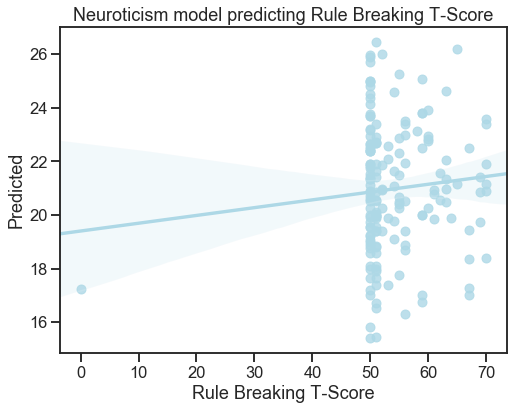

In [127]:
# apply predictions to holdout data
predicted_neuroticism = test.similarity(stats_neuroticism['weight_map'],'dot_product') + stats_neuroticism['intercept']

data_neurotic = pd.DataFrame(data={'SubjectID':test.X['ID'],'Predicted':predicted_neuroticism,'rule_tscore':test.X['ASRM_154']})

# scatter plot of predicted values
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("ticks")
with sns.plotting_context(context='talk',font_scale=1):
    sns.regplot(data=data_neurotic,x='rule_tscore',y='Predicted', color='lightblue').set_title("Neuroticism model predicting Rule Breaking T-Score")
    plt.xlabel('Rule Breaking T-Score')

# calculate fit metrics    
fit = pearsonr(data_neurotic.rule_tscore, data_neurotic.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_neurotic.rule_tscore, data_neurotic.Predicted))

print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse)) 

### Instrusive

Holdout: R = 0.20261216418702446, p = 0.009270909279658771, R2 = 0.041051689076549755, RMSE =  8.789409849645443


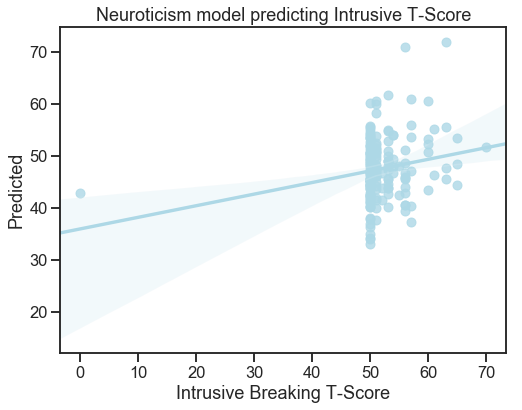

In [174]:
# apply predictions to holdout data
predicted_neuroticism = test.similarity(stats_neuroticism['weight_map'],'dot_product') + stats_neuroticism['intercept']

data_neurotic = pd.DataFrame(data={'SubjectID':test.X['ID'],'Predicted':predicted_neuroticism,'intrusive_tscore':test.X['ASRM_155']})

# scatter plot of predicted values
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("ticks")
with sns.plotting_context(context='talk',font_scale=1):
    sns.regplot(data=data_neurotic,x='intrusive_tscore',y='Predicted', color='lightblue').set_title("Neuroticism model predicting Intrusive T-Score")
    plt.xlabel('Intrusive Breaking T-Score')

# calculate fit metrics    
fit = pearsonr(data_neurotic.intrusive_tscore, data_neurotic.Predicted)
r2 = fit[0]**2
rmse = np.sqrt(mean_squared_error(data_neurotic.intrusive_tscore, data_neurotic.Predicted))

print("Holdout: R = %s, p = %s, R2 = %s, RMSE =  %s" % (fit[0], fit[1], r2, rmse)) 